## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('Churn.csv', index_col = 'RowNumber')

### Предобработка и исследовательский анализ

Проведем исследовательский анализ данных и предобработку датасета

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Приведем признаки датафрейма к нижнему регистру

In [5]:
df.columns = df.columns.str.lower()
df.head()

,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Признаки `customerid` и `surname` не нужны для обучения модели, мы можем их удалить

In [6]:
df = df.drop(['customerid', 'surname'], axis=1)
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Изучим признак `tenure`, так как мы имеем в нем пропущенные значения

In [7]:
df['tenure'].value_counts(normalize=True, dropna=False)

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: tenure, dtype: float64

Почти 9% данных имеют пропуски в признаке. Заполним пропущенные значения случайным числом и заменим тип переменной с `float` на `int` для экономии памяти

In [8]:
def fill_missing(column_val):
    if np.isnan(column_val) == True: 
        column_val = np.random.randint(0,11)
    else:
         column_val = column_val
    return column_val

In [9]:
df['tenure'] = df['tenure'].apply(fill_missing).astype('int')
df['tenure'].value_counts(normalize=True, dropna=False)

2     0.1042
1     0.1031
8     0.1020
7     0.1019
5     0.1019
3     0.0997
4     0.0974
9     0.0962
6     0.0959
10    0.0521
0     0.0456
Name: tenure, dtype: float64

Признаки `geography` и `gender` имеют тип `object`. Применим One-Hot-Encoding для преобразования признаков в подходящие для обучения

In [10]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Наконец оценим мультиколлинеарность признаков, построив хитмап

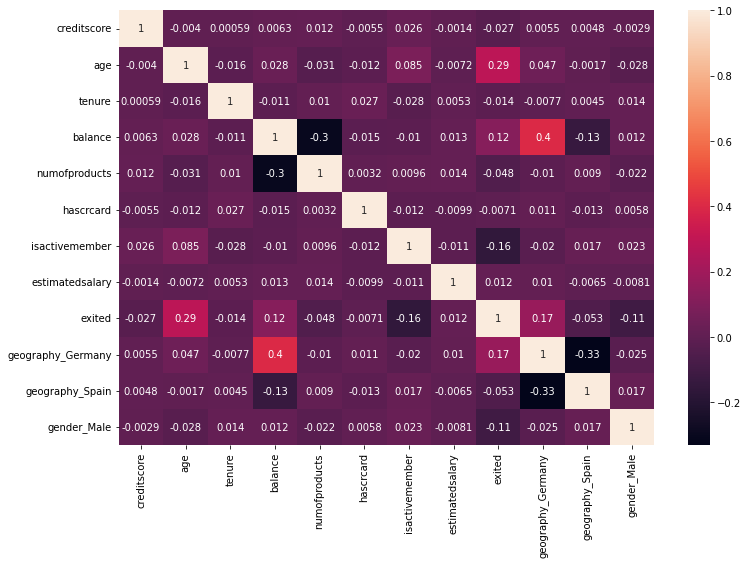

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

В датафрейме есть несколько коррелирующих между собой признаков, но не настолько сильно, чтобы их удалять

### Подготовка выборок

Создадим выборки `feature` и `target`, после разделим выборки на обучающую, валидационную и тестовую

In [12]:
features = df.drop('exited', axis=1)
target = df['exited']

In [13]:
features_train, features_int, target_train, target_int = train_test_split(
    features, 
    target,
    test_size=0.4,
    stratify=target,
    random_state=12345
)                                                                      

In [14]:
#Проверим размеры выборок
features_train.shape[0], features_int.shape[0]

(6000, 4000)

In [15]:
#Разделим промежуточную выборку пополам, на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_int,
    target_int,
    test_size=0.5,
    stratify=target_int,
    random_state=12345
)     

In [16]:
features_valid.shape[0], features_test.shape[0]

(2000, 2000)

Скалируем значения выборок

In [17]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
2838,-1.040434,0.953312,6,0.774657,1,0,1,-0.119110,1,0,0
9926,0.454006,-0.095244,2,1.910540,1,1,1,-0.258658,0,0,0
8747,0.103585,-0.476537,8,0.481608,2,0,1,1.422836,0,0,1
661,-0.184996,0.190726,0,0.088439,1,1,1,-1.160427,1,0,0
3611,-0.720933,1.620574,1,0.879129,1,1,0,0.113236,0,0,0


### Выводы

Данные были обработаны и подготовлены для обучения:
1) Исправлены ошибки в датафрейме, удалены лишние признаки, заполнены пропуски  
2) Закодированы категориальные признаки с помощью методики OHE  
3) Численные признаки отмасштабированы  
4) Построена матрица корреляции между признаками для выявления зависимых признаков  
5) Созданы выборки для обучения, верификации и тестирования моделей

Данные готовы, можно переходить к обучению моделей

## Исследование задачи

Проверим дисбаланс классов на примере обучающей выборки

In [18]:
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: exited, dtype: float64

Соотношение отрицательных и положительных классов приблизительно 80:20. Налицо явный дисбаланс. Попробуем обучить модели без поправок на дисбаланс.  
В качестве метрик выбираем F1-score и AUC-ROC

Обучим каждую модель и оценим значения метрик F1 и AUC-ROC. Кроме того, для каждой модели построим график кривой ошибок и сравним его со случайной моделью

In [19]:
#Решающее дерево

model_t = DecisionTreeClassifier(random_state=12345)

model_t.fit(features_train, target_train)

prediction = model_t.predict(features_valid)
probabilities = model_t.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели решающего дерева: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели решающего дерева: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели решающего дерева: 0.5172824791418357
AUC-ROC-score модели решающего дерева: 0.6987203172726376


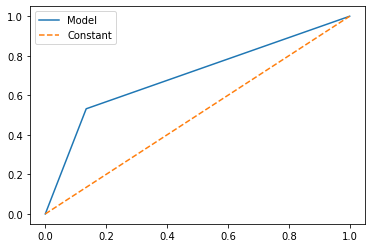

In [20]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Модель решающего дерева на несбалансированной выборке показывает себя слабо. Она смогла обучиться и без настройки гиперпараметров, но метрики оставляют желать лучшего

In [21]:
#Случайный лес

model_f = RandomForestClassifier(n_estimators=10, random_state=12345)

model_f.fit(features_train, target_train)

prediction = model_f.predict(features_valid)
probabilities = model_f.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели случайного леса: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели случайного леса: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели случайного леса: 0.5940298507462687
AUC-ROC-score модели случайного леса: 0.841641571829737


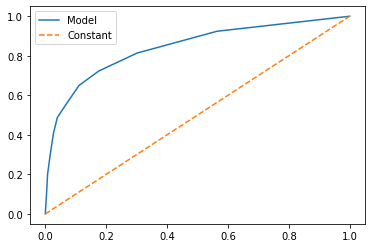

In [22]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Модель случайного леса показывает себя гораздо лучше модели решающего дерева. F1-score практически достиг заданного показателя, площадь кривой отлична от 0.5. Эту модель мы будем настраивать далее

In [23]:
#Логистическая регрессия
model_r = LogisticRegression(solver='liblinear',
                            random_state=12345)

model_r.fit(features_train, target_train)

prediction = model_r.predict(features_valid)
probabilities = model_r.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели логистической регрессии: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели логистической регрессии: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели логистической регрессии: 0.3071297989031079
AUC-ROC-score модели логистической регрессии: 0.7872342718494434


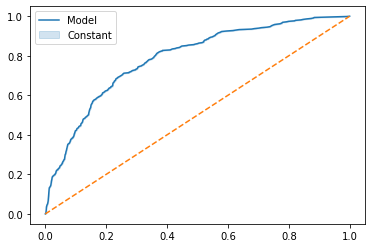

In [24]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Модель логистической регрессии плохо показывает себя на несбалансированных выборках, но при этом у нее неплохой показатель AUC-ROC. Учитывая то, что она обучается в разы быстрее леса (особенно после увеличения глубины и количества оценщиков последнего), мы можем попробовать получить удовлетворительные варианты и у нее.

### Выводы

Мы быстро обучили несколько тестовых моделей и посмотрели, как они себя показывают на несбалансированных данных. Учитывая распределение целевого признака (~80:20 для отрицательного и положительного класса соответственно), нам необходимо попробовать обработать выборки (проведя upsampling и downsampling), или же попробовать задать модели равный вес классов. Для оценки сбалансированных выборок мы берем наши модели леса и регрессии.

## Борьба с дисбалансом

Для борьбы с дисбалансом классов в выборке мы последовательно применим следующие шаги:  
1) Сначала попробуем задать одинаковый вес в каждой модели  
2) Затем увеличим выборку - "upsampling"  
3) Затем попробуем уменьшить выборку - "downsampling" 

На каждом шаге мы будем мониторить метрики F1 и AUC-ROC. После того, как мы достигнем лучших результатов на исправленных выборках, мы можем настроить гиперпараметры выбранной модели и перейти к ее тестированию

### Взвешивание классов

Попробуем задать `class_weight='balanced'` нашим моделям

In [25]:
#Случайный лес
model_f = RandomForestClassifier(n_estimators=10, 
                                 random_state=12345,
                                 class_weight='balanced'
                                )

model_f.fit(features_train, target_train)

prediction = model_f.predict(features_valid)
probabilities = model_f.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели случайного леса: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели случайного леса: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели случайного леса: 0.5709969788519638
AUC-ROC-score модели случайного леса: 0.8310994309784214


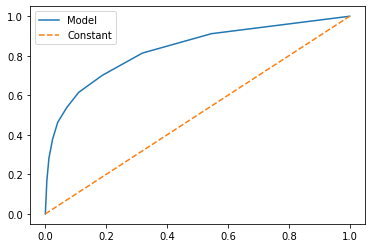

In [26]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Изменение данного параметра ухудшило метрики нашей модели. Посмотрим на регрессию

In [27]:
#Логистическая регрессия
model_r = LogisticRegression(solver='liblinear',
                            class_weight='balanced',
                            random_state=12345)

model_r.fit(features_train, target_train)

prediction = model_r.predict(features_valid)
probabilities = model_r.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели логистической регрессии: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели логистической регрессии: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели логистической регрессии: 0.5289982425307558
AUC-ROC-score модели логистической регрессии: 0.7935757217459848


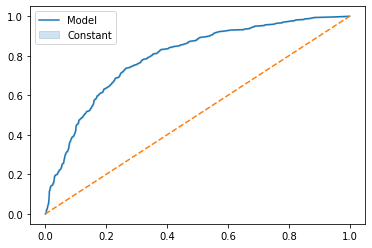

In [28]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

В случае регрессии данный параметр помог (больше, чем в 1,5 раза) увеличить метрику F1-score; площадь под кривой также увеличилась

#### Результаты и выводы

Параметр `class_weight` не стоит задавать для модели случайного леса, но он помогает логистической регрессии. В дальнейшем попробуем у нее задавать и не задавать этот параметр

### Upsampling

Попробуем увеличить размер выборки с положительным классом в 4 раза - чтобы соотношение целевых классов было 1:1

In [29]:
# Функция, принимающая выборки и увеличивающая их в repeat раз

def upsample(features, target, repeat):
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [30]:
# Создадим upsampled обучающую выборку
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4) 
target_train_upsampled.value_counts(normalize=True)

1    0.50569
0    0.49431
Name: exited, dtype: float64

Обучим наши модели на новых выборках. В случае регрессии применим два варианта - с параметром `class_weight` и без

In [31]:
#Случайный лес
model_f = RandomForestClassifier(n_estimators=10, 
                                 random_state=12345,
                                )

model_f.fit(features_train_upsampled, target_train_upsampled)

prediction = model_f.predict(features_valid)
probabilities = model_f.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели случайного леса: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели случайного леса: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели случайного леса: 0.592797783933518
AUC-ROC-score модели случайного леса: 0.8383546100601045


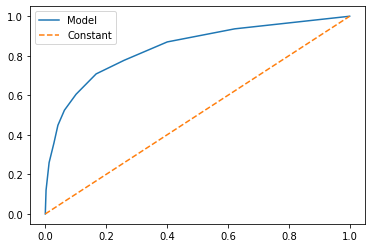

In [32]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Увеличение выборки повысило метрики модели случайного леса. Посмотрим на модель регрессии

In [33]:
# Логистическая регрессия
model_r = LogisticRegression(solver='liblinear',
                            random_state=12345)

model_r.fit(features_train_upsampled, target_train_upsampled)

prediction = model_r.predict(features_valid)
probabilities = model_r.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели логистической регрессии без параметра: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели логистической регрессии без параметра: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели логистической регрессии без параметра: 0.5251299826689775
AUC-ROC-score модели логистической регрессии без параметра: 0.7936326854862548


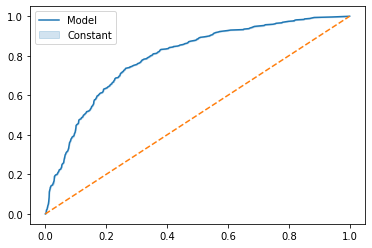

In [34]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Без параметра на увеличенной выборке модель логистической регрессии показывает результаты хуже, чем с параметром без увеличения выборки. Попробуем задать параметр

In [35]:
#Логистическая регрессия
model_r = LogisticRegression(solver='liblinear',
                            class_weight='balanced',
                            random_state=12345)

model_r.fit(features_train_upsampled, target_train_upsampled)

prediction = model_r.predict(features_valid)
probabilities = model_r.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели логистической регрессии с параметром: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели логистической регрессии с параметром: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели логистической регрессии с параметром: 0.5289982425307558
AUC-ROC-score модели логистической регрессии с параметром: 0.793555707458863


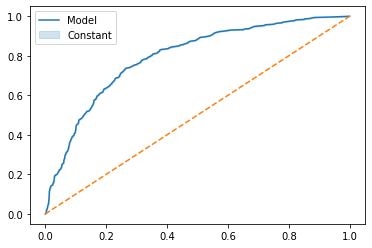

In [36]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

На увеличенной выборке с параметром модель регрессии показывает себя немного хуже, чем на обычной выборке. Следовательно, для обучения модели регрессии не имеет смысла увеличивать выборку.

#### Результаты и выводы

Модель случайного леса имеет более высокие метрики F1 и AUC-ROC, нежели модель логистической регрессии. Увеличенная выборка увеличила метрики модели леса, но модель регрессии показывает себя на ней хуже, чем на обычной выборке. Попробуем уменьшить выборку и сравнить результаты

### Downsampling

Уменьшим нашу обучающую выборку, чтобы соотношение целевого признака было 1:1. Как и в случае с увеличенной выборкой, для регрессии построим две модели - с параметром и без

In [37]:
# Функция принимает две выборки и долю, возвращает уменьшенные выборки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [38]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

In [39]:
target_train_downsampled.value_counts(normalize=True)

1    0.505795
0    0.494205
Name: exited, dtype: float64

Обучим модели, сравним метрики

In [40]:
#Случайный лес
model_f = RandomForestClassifier(n_estimators=10, 
                                 random_state=12345,
                                )

model_f.fit(features_train_downsampled, target_train_downsampled)

prediction = model_f.predict(features_valid)
probabilities = model_f.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели случайного леса: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели случайного леса: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели случайного леса: 0.5776458951533135
AUC-ROC-score модели случайного леса: 0.8292242462311556


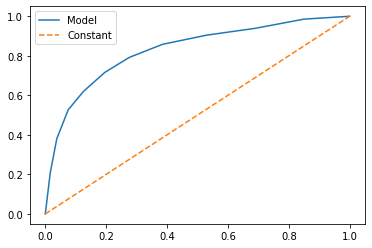

In [41]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Модель случайного леса на уменьшенной выборке показала себя хуже, чем на выборке без изменений. Очевидно, такой способ не подходит для нее. Проверим регрессию

In [42]:
# Логистическая регрессия
model_r = LogisticRegression(solver='liblinear',
                            random_state=12345)

model_r.fit(features_train_downsampled, target_train_downsampled)

prediction = model_r.predict(features_valid)
probabilities = model_r.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели логистической регрессии без параметра: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели логистической регрессии без параметра: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели логистической регрессии без параметра: 0.5283993115318416
AUC-ROC-score модели логистической регрессии без параметра: 0.7926581436594738


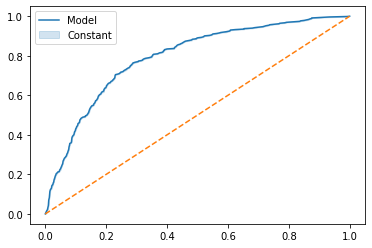

In [43]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Увы, но уменьшение выборки так же не помогло модели регрессии. Проверим, что будет с метриками, если мы зададим параметр

In [44]:
#Логистическая регрессия
model_r = LogisticRegression(solver='liblinear',
                            class_weight='balanced',
                            random_state=12345)

model_r.fit(features_train_upsampled, target_train_upsampled)

prediction = model_r.predict(features_valid)
probabilities = model_r.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]

print(f'F1-score модели логистической регрессии с параметром: {f1_score(target_valid, prediction)}')
print(f'AUC-ROC-score модели логистической регрессии с параметром: {roc_auc_score(target_valid, probabilities_one)}')

F1-score модели логистической регрессии с параметром: 0.5289982425307558
AUC-ROC-score модели логистической регрессии с параметром: 0.793555707458863


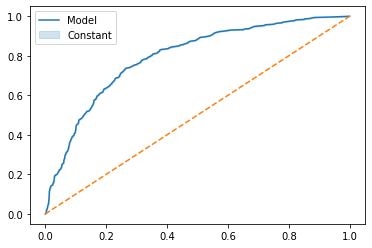

In [45]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)
sns.lineplot(fpr, tpr)
sns.lineplot([0,1], [0,1], linestyle='dashed')
plt.legend(labels=['Model', 'Constant'])
plt.show()

Метрики немного увеличились, но все еще далеко от порогового значения

#### Результаты и выводы

Было проведено уменьшение выборки для достижения баланса классов. К сожалению, это не привело к улучшению метрик моделей - F1-score и AUC-ROC у регрессии и случайного леса практически не изменился.
Опираясь на показатели метрик, только модель случайного леса обладает достаточным показателем F1-score. Подберем для нее лучшие гиперпараметры и обучим на увеличенных тренировочной + валидационных выборках перед тестированием

### Подбор гиперпараметров модели и ее обучение

In [46]:
model_f = None
best_estimators = 0
best_depth = 0
best_score = 0

for depth in tqdm(range(1,16,1)):
    for estimators in range(10,150,10):
        model = RandomForestClassifier(random_state=12345,
                                     max_depth=depth,
                                     n_estimators=estimators)
        model.fit(features_train_upsampled, target_train_upsampled)
        prediction = model.predict(features_valid)
        score = f1_score(target_valid, prediction)
        
        if score > best_score:
            model_f = model
            best_estimators = estimators
            best_depth = depth
            best_score = score

print(f'''Лучший F1-score:{best_score}, 
          Глубина: {best_depth},
          Количество оценщиков: {best_estimators}'''
     )

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:39<00:00,  6.65s/it]

Лучший F1-score:0.6570155902004454, 
          Глубина: 10,
          Количество оценщиков: 80


Объединим выборки train и valid, чтобы не терять данные, после используя RandomizedSearchCv подберем гиперпараметры модели

In [47]:
features_train = pd.concat([features_train_upsampled, features_valid])
target_train = pd.concat([target_train_upsampled, target_valid])
features_train, target_train = shuffle(features_train, target_train, random_state=12345)

In [48]:
model_f = RandomForestClassifier(random_state=12345,
                               max_depth=11,
                               n_estimators=90)
model_f.fit(features_train, target_train)
prediction_f = model_f.predict(features_valid)

probabilities_f = model_f.predict_proba(features_valid)
probabilities_one_f = probabilities_f[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_f)

print(f'''Финальное значение метрик:
        F1-score: {f1_score(target_valid, prediction_f)},
        AUC-ROC-score: {roc_auc_score(target_valid, probabilities_one_f)}
        ''')

Финальное значение метрик:
        F1-score: 0.7897310513447432,
        AUC-ROC-score: 0.9593186520839492
        


Лучшие значения метрик мы получили на `max_depth = 10` и `n_estimators = 140`. Модель готова к тестированию.

### Выводы

В этой части работы было проведено исследование возможности устранения дисбаланса классов в датасете.  
Были использованы следующие методы: взвешивание классов, увеличение выборки, уменьшение выборки.  
По результатам работы была отобрана модель случайного леса, которая имела лучшие показатели метрик F1 и AUC-ROC.  
Были подобраны оптимальные гиперпараметры данной модели.  

## Тестирование модели

Все готово к тестированию модели. Возьмем нашу модель и предскажем целевой признак для тестовой выборки, сравним метрики, построим график.

In [49]:
prediction_test = model_f.predict(features_test)

probabilities_test = model_f.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
    
f1 = f1_score(target_test, prediction_test)
roc_auc = roc_auc_score(target_test, probabilities_one_test)
    
print(f'F1-score: {f1}, AUC-ROC-score: {roc_auc}')

F1-score: 0.6077481840193705, AUC-ROC-score: 0.8541114303826169


In [50]:
fpr_test, tpr_test, thresholds_test = roc_curve(target_test, probabilities_one_test)

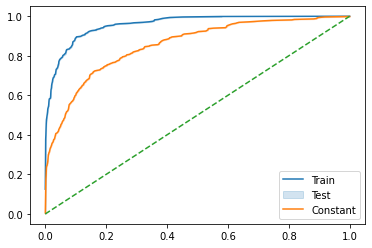

In [51]:
roc_train = sns.lineplot(fpr, tpr)
roc_test = sns.lineplot(fpr_test, tpr_test)
dummy_roc = sns.lineplot([0,1], [0,1], linestyle='dashed')
roc_train.plot()
roc_test.plot()
dummy_roc.plot()
plt.legend(labels = ['Train', 'Test', 'Constant'])
plt.show()

Налицо большая разница между значениями метрик на обучающей и тестовых выборках. Очевидно, что модель была переучена. Несмотря на этот факт, мы смогли достигнуть установленного порога F1-score в 0.59

**Результаты по качеству моделей (округление до тысячных):**

Дисбаланс классов:

|             |   Решающее дерево|     Случайный лес|         Регрессия|
|-------------|------------------|------------------|------------------| 
|  F1-score   |             0.513|             0.584|             0.308|
|AUC-ROC-score|             0.696|            0.832 |             0.787|

Взвешивание классов:

|             |     Случайный лес|         Регрессия|
|-------------|------------------|------------------| 
|  F1-score   |             0.553|            0.5299|
|AUC-ROC-score|             0.824|             0.794|

Upsampling:

|             |Случайный лес|Регрессия (c взвешиванием)|Регрессия (без взвешивания)|
|-------------|-------------|--------------------------|---------------------------| 
|  F1-score   |        0.608|                    0.5299|                      0.524|
|AUC-ROC-score|        0.834|                     0.794|                      0.794|

Downsampling:

|             |Случайный лес|Регрессия (c взвешиванием)|Регрессия (без взвешивания)|
|-------------|-------------|--------------------------|---------------------------| 
|  F1-score   |        0.596|                    0.5299|                      0.528|
|AUC-ROC-score|        0.834|                     0.794|                      0.793|

## Результаты и выводы

In [52]:
importance = model_f.feature_importances_
for i,v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

Feature: 0, Score: 0.08997
Feature: 1, Score: 0.30315
Feature: 2, Score: 0.04952
Feature: 3, Score: 0.12981
Feature: 4, Score: 0.19116
Feature: 5, Score: 0.01192
Feature: 6, Score: 0.05808
Feature: 7, Score: 0.09002
Feature: 8, Score: 0.04456
Feature: 9, Score: 0.01157
Feature: 10, Score: 0.02024


In [53]:
feature_importance = dict(zip(features_train.columns, importance))
feature_importance = pd.DataFrame(data=feature_importance, index=[0])
feature_importance

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
0,0.089968,0.303147,0.049517,0.129813,0.191165,0.011917,0.058082,0.090023,0.044561,0.011571,0.020238


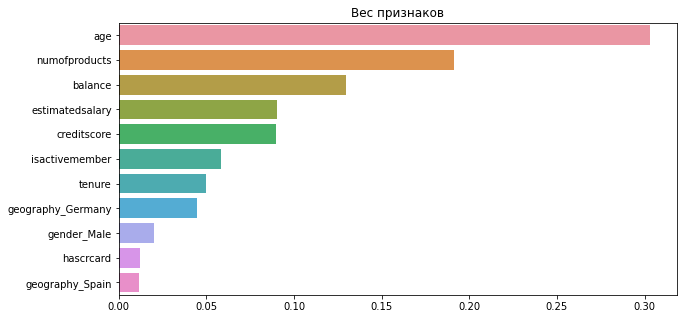

In [54]:
plt.figure(figsize=(10,5))
sns.barplot(data=feature_importance.sort_values(by=0, axis=1, ascending=False), orient='h')
plt.title('Вес признаков')
plt.show()

Исходя из веса признаков для выбранной модели, самыми важными признаками для предсказания модели были возраст клиента, баланс на счете и количество продуктов банка, используемых клиентом.  
При этом малое значение имели такие признаки, как наличие кредитной карты, пол или место проживания клиента.  

В ходе выполнения работы были проведены следующие мероприятия:  
1) Данные были подготовлены для обучения, заполнены пропуски, удалены некоторые признаки  
2) Три модели были обучены на неподготовленных данных, две из них были выбраны для обучения на обработанных данных  
3) Проверено три способа борьбы с дисбалансом классов в выборках - в результате, был выбран один из них (upsampling) и одна модель (random forest)  
4) Для выбранной модели были подобраны оптимальные гиперпараметры, показывающие высокие показатели метрик  
5) Модель была дообучена и проверена на тестовой выборке  
По результатам проверки была подготовлена, протестирована и проверена на адекватность модель, которая превышает заданное пороговое значение метрики F1-score